# COMP 755

Plan for today

0. Covariance refresher
1. More Mixture Models
    * Mixture of Gaussians with Covariance
2. MapReduce
3. Debugging EM algorithms

$$
\renewcommand{\xx}{\mathbf{x}}
\renewcommand{\yy}{\mathbf{y}}
\renewcommand{\zz}{\mathbf{z}}
\renewcommand{\vv}{\mathbf{v}}
\renewcommand{\bbeta}{\boldsymbol{\mathbf{\beta}}}
\renewcommand{\mmu}{\boldsymbol{\mathbf{\mu}}}
\renewcommand{\ssigma}{\boldsymbol{\mathbf{\sigma}}}
\renewcommand{\reals}{\mathbb{R}}
\renewcommand{\loglik}{\mathcal{LL}}
\renewcommand{\penloglik}{\mathcal{PLL}}
\renewcommand{\likelihood}{\mathcal{L}}
\renewcommand{\Data}{\textrm{Data}}
\renewcommand{\given}{ \big| }
\renewcommand{\MLE}{\textrm{MLE}}
\renewcommand{\EE}{\mathbb{E}}
\renewcommand{\KL}{\textrm{KL}}
\renewcommand{\Bound}{\mathcal{B}}
\renewcommand{\tth}{\textrm{th}}
\renewcommand{\Gaussian}[2]{\mathcal{N}\left(#1,#2\right)}
\renewcommand{\norm}[1]{\left\lVert#1\right\rVert}
\renewcommand{\ones}{\mathbf{1}}
\renewcommand{\diag}[1]{\textrm{diag}\left( #1 \right)}
\renewcommand{\sigmoid}[1]{\sigma\left(#1\right)}
\renewcommand{\myexp}[1]{\exp\left\{#1\right\}}
\renewcommand{\mylog}[1]{\log\left\{#1\right\}}
\renewcommand{\argmax}{\mathop{\textrm{argmax}}}
\renewcommand{\new}{\textrm{new}}
\renewcommand{\old}{\textrm{old}}
\renewcommand{\bb}{\mathbf{b}}
\renewcommand{\ba}{\mathbf{a}}
\renewcommand{\BB}{\mathbf{B}}
\renewcommand{\BA}{\mathbf{A}}
\renewcommand{\BC}{\mathbf{C}}
\renewcommand{\SSS}{\mathbf{S}}
\renewcommand{\tr}[1]{\textrm{tr}\left\{#1\right\}}
$$

In [16]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
def generate_data(N,d,K,proby,mus,As=None):    
    if As is None:
        As = numpy.zeros((d,d,K))
        for k in range(K):
            As[:,:,k] = numpy.eye(d)
    ys = numpy.zeros(N,dtype='int')
    xs = numpy.zeros((d,N))
    for i in range(N):
        # Sample class according to the prior p(y)
        # in this case it is uniform
        ys[i] = numpy.random.choice(K,1)[0]      
        # Sample feature values according to p(x|y)
        # In this case, x ~ N(mmu[y[i]],sigma2*I)
        # To accomplish this, draw z1,z2 ~ N(0,I)    
        z = numpy.random.randn(2,1)
        # transform by matrix A and shift by class mean
        A = As[:,:,ys[i]].squeeze()
        mu = mus[:,ys[i]]
        Az = numpy.dot(A,z) 
        x = Az + mu[:,numpy.newaxis]
        xs[:,i] = x[:,0]
    return xs,ys

def plot_covariance(mu,Sigma,std_devs,color):
    N = 50
    alphas = numpy.linspace(0,2*numpy.pi,N)
    x = numpy.cos(alphas)
    y = numpy.sin(alphas)
    xy = numpy.vstack((x,y))
    d,v = numpy.linalg.eig(Sigma)
    d = numpy.sqrt(d)
    xy = std_devs*numpy.dot(numpy.dot(v,numpy.diag(d)),xy) + mu[:,numpy.newaxis]
    plt.plot(xy[0,:],xy[1,:],'w-',linewidth=6)
    plt.plot(xy[0,:],xy[1,:],color+'-',linewidth=3)
    
    
def plot_samples(xs,ys,mus=None,Sigmas=None,colors=['r','g','b','k','c','m'],labels=None):
    N = xs.shape[1]
    if not ys is None:        
        K = numpy.max(ys)+1        
        for c in range(K):
        # indices of samples assigned to class c
            ind = [i for i in range(N) if ys[i]==c]
            if labels is None:
                label = "Samples in cluster " + str(c)
            else:
                label = labels[c]
            plt.plot(xs[0,ind],xs[1,ind],colors[c]+'.',label=label)   
            if not mus is None:
                plt.plot(mus[0,c],mus[1,c],'wx',markersize=9,markeredgewidth=5)
                plt.plot(mus[0,c],mus[1,c],colors[c]+'x',markersize=7,markeredgewidth=3)
            if not Sigmas is None:
                plot_covariance(mus[:,c],Sigmas[:,:,c],2.0,colors[c])
        plt.legend(loc=2, bbox_to_anchor=(1,1))
    else:
        plt.plot(xs[0,:],xs[1,:],'.')

def plot_samples_post(xs,qs,mus=None,Sigmas=None, colors=['r','g','b','k','c','m'], 
                      highlight_samples=None,
                      label_means=False):
    K,N = qs.shape
    for i in range(N):
        plt.plot(xs[0,i],xs[1,i],'o',color=qs[:,i])
    if not highlight_samples is None:
        for (i,d) in highlight_samples:
            s = ''
            for j in range(3):
                if j>0:
                    s = s + '\n'
                s = s + '$p(h_{{{}}}={} |x_{{{}}})=${:1.4f}'.format(i,j,i,qs[j,i])
            if d==0:
                plt.annotate(s,xy=(xs[0,i]+0.5,xs[1,i]-1.0),
                         bbox=dict(facecolor='white'),
                         fontsize=15)
                plt.arrow(xs[0,i]+0.5,xs[1,i],-0.5,0)
            if d==-1:
                plt.annotate(s,xy=(xs[0,i]-2.0,xs[1,i]-4.5),
                         bbox=dict(facecolor='white'),
                         fontsize=15)
                plt.arrow(xs[0,i],xs[1,i]-4.5,0,4.5)
    for c in range(K):
    # indices of samples assigned to class c
        if not mus is None:
            plt.plot(mus[0,c],mus[1,c],'kx',markersize=9,markeredgewidth=5)
            plt.plot(mus[0,c],mus[1,c],'wx',markersize=7,markeredgewidth=3)            
            if label_means:
                plt.annotate('$\mu_{}$'.format(c),xy=(mus[0,c]+1,mus[1,c]-1),
                              bbox=dict(facecolor='white'),
                              fontsize=15)
        if not Sigmas is None:
            plot_covariance(mus[:,c],Sigmas[:,:,c],2.0,colors[c])




Sigma0
[[ 4.  0.]
 [ 0.  4.]]
Sigma1
[[  0.25   0.  ]
 [  0.    25.  ]]
Sigma2
[[ 4. -4.]
 [-4.  8.]]


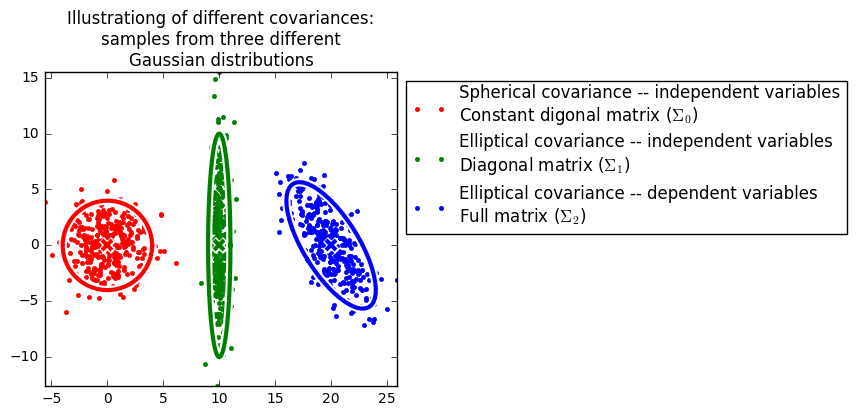

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
K = 3
d=2
mus = 10*numpy.asarray([[0.0,1.0,2.0],[0.0,0.0,0.0]])
As = numpy.asarray([[[2.0,0.0],[0.0,2.0]],
                    [[0.5,0.0],[0.0,5.0]],
                    [[2.0,-2.0],[0.0,2.0]]])
As = numpy.swapaxes(As,0,2)
Sigmas = numpy.zeros((d,d,K))
for c in range(K):
    A = As[:,:,c]
    Sigmas[:,:,c] = numpy.dot(A,A.transpose())
    print "Sigma"+str(c)
    print Sigmas[:,:,c]

proby = [1./K]*K
numpy.random.seed(1)
xs,ys = generate_data(1000,2,K,proby,mus,As)

plot_samples(xs,ys,mus=mus,Sigmas=Sigmas,
             labels=['Spherical covariance -- independent variables\nConstant digonal matrix ($\Sigma_0$)',
                       'Elliptical covariance -- independent variables\nDiagonal matrix ($\Sigma_1$)',
                       'Elliptical covariance -- dependent variables\nFull matrix ($\Sigma_2$)'])
plt.axis('image')
plt.title('Illustrationg of different covariances:\nsamples from three different\nGaussian distributions');

# Our second EM algorithm 

The model
$$
\begin{aligned}
p(h\mid \alpha) &= \alpha_h \\
p(\xx \mid h,\mu) &= (2\pi)^{-\frac{d}{2}}\color{red}{|\Sigma_h|^{-\frac{1}{2}}} \myexp{-\frac{1}{2}(\xx - \mu_{h_t})^T\color{red}{\Sigma_h^{-1}}(\xx - \mu_{h_t})} \\
\end{aligned}
$$
is a variant of ** Mixture of Gaussians. ** Note that we introduced a covariance matrix per cluster.

* Hidden variables: $h_t$ -- cluster membership for sample $t$
* Parameters: $\Theta = (\underbrace{\alpha_1,...,\alpha_K}_{\textrm{proportions}},\underbrace{\mu_1, ...,\mu_K}_{\textrm{means}},\underbrace{\Sigma_1,...,\Sigma_K}_{\textrm{covariances}})$

# Our second EM algorithm 

We plug-in probabilities $p(\xx_t\mid h_t,\Theta)$ and $p(h_t\mid \alpha)$ in the bound
$$
\begin{aligned}
\Bound(\Theta,q) &&= \sum_{t=1}^T \sum_{h_t} q_t(h_t)&\log \frac{ p(\xx_t,h_t\mid \Theta) }{ q_t(h_t) } \\
&&=  \sum_{t=1}^T \sum_{h_t} q_t(h_t) &\left[ \log \alpha_{h_t} -\frac{d}{2} \log (2\pi)-\color{red}{\frac{1}{2}\log|\Sigma_{h_t}|}\right. \\
&&& \left.  -\frac{1}{2}(\xx_t - \mu_{h_t})^T\color{red}{\Sigma_{h_t}^{-1}}(\xx_t - \mu_{h_t}) \right] \\
&&- \sum_{t=1}^T \sum_{h_t} q_t(h_t)& \log q_t(h_t)
\end{aligned}
$$


In [18]:
# broadcasting tutorial
x = numpy.asmatrix([[1,2,3],[4,5,6]])
print "Data matrix:"
print x
mu = numpy.asarray([1,2])
print "Mean as a row vector:"
print mu
print "Mean as a column vector:"
print mu[:,numpy.newaxis]
print "Broadcast subtraction across columns:"
print x - mu[:,numpy.newaxis]

Data matrix:
[[1 2 3]
 [4 5 6]]
Mean as a row vector:
[1 2]
Mean as a column vector:
[[1]
 [2]]
Broadcast subtraction across columns:
[[0 1 2]
 [2 3 4]]



# Our second EM algorithm -- E-step

The E-step
$$
\begin{aligned}
q_t(h_t = k) &= p(h_t =k \mid \xx_t, \mu)  = \frac{p(\xx_t,h_t = k \mid \mu)}{\underbrace{\sum_c p(\xx_t,h_t=c \mid \mu)}_{\textrm{same for all values of } k}}\\
 &\propto p(\xx_t,h_t = k\mid \mu)\\
        &=  \alpha_{h_t} (2\pi)^{-\frac{d}{2}}\color{red}{|\Sigma_{h_t}^{-1}|} \myexp{-\frac{1}{2}(\xx - \mu_{h_t})^T\color{red}{\Sigma_{h_t}^{-1}}(\xx - \mu_{h_t})}
\end{aligned}
$$ 
Implementation:
```
q = numpy.zeros((K,N))           # clusters x samples
q = logjointp(x,Theta)           # compute all joints at once
loglik = numpy.sum(logsumexp(q)) # compute loglikelihood
q = q - logsumexp(q)             # normalizing across clusters
```


In [19]:
def logjointp(xs,mus,Sigmas,logph = None):    
    # compute log p(x,h|mus,Sigmas)
    # for all values of h (1..K)    
    d = xs.shape[0]
    N = xs.shape[1]
    K = mus.shape[1]    
    # dimensions are consistent
    assert(mus.shape[0] == d and 
           Sigmas.shape[0] == d and
           Sigmas.shape[1] == d and
           Sigmas.shape[2] == K)
    if logph is None:
        # no prior for clusters provided
        # assume uniform probability
        logph = numpy.asarray([1./K]*K)
        
    logp = numpy.zeros( (K,N) )
    for k in range(K):
        # get the covaraiance and squeeze
        # the last dimension to get d x d matrix
        Sigma = Sigmas[:,:,k].squeeze()        
        mu = mus[:,k]
        invSigma = numpy.linalg.inv(Sigma)
        ###
        # For each sample we need to compute: 
        #    (x - mu) Sigma^{-1} (x - mu)
        # We will do this at once for all samples
        #        
        # (x-mu)^T  for all rows of matrix xs
        # mu[:,numpy.newaxis] turns row vector into a column
        res = xs - mu [:,numpy.newaxis]
        # (x-mu)^T Sigma^{-1} for all rows of matrix X
        res_T_invSigma = numpy.dot(res.transpose(),invSigma)              
        # need to compute inner product between 
        # *corresponding* rows of ((x-mu)^T Sigma^{-1}) and (x-mu)
        res_T_invSigma_res = numpy.sum(res_T_invSigma.transpose()*res,axis=0)        
        logp[k,:] = -0.5*res_T_invSigma_res
        logp[k,:] = logp[k,:] - d/2.*numpy.log(2.*numpy.pi)
        logp[k,:] = logp[k,:] - 0.5*numpy.log(numpy.linalg.det(Sigma))
        logp[k,:] = logp[k,:] + logph[k]
    return logp
                            

# Our second EM algorithm -- M-step


Updates for parameters of prior probability $p(h \mid \alpha)$
$$
\alpha^*_c = \frac{\sum_t q_t(h_t = c)}{N}
$$
Updates for means of clusters
$$
\mu_c^* = \frac{\sum_t q_t(h_t = c) \xx_t}{\sum_t q_t(c)} 
$$
Updates for covariances of clusters
$$
\Sigma_c^* = \frac{\sum_t q_t(h_t = c) (\xx_t - \mu^*_c)(\xx_t-\mu^*_c)^T}{\sum_t q_t(c)} 
$$
Work out means and covariances on the board.


# Matrix calculus 

$$\begin{aligned}
\nabla_{\ba} \bb^T\ba &= \bb\\
\nabla_{\ba} \ba^T\BA\ba &= (\BA + \BA^T)\ba\\
\nabla_{\BA} \tr{\BB\BA} &= \BB^T\\
\nabla_{\BA} \log\lvert\BA\rvert &= (\BA^{-1})^T\\
\nabla_{\BA} -\log\lvert\BA\rvert &= (\BA)^T\\
\tr{\BA+\BB} &= \tr{\BA} + \tr{\BB}\\
\tr{\BA\BB\BC} = \tr{\BC\BA\BB} &= \tr{\BB\BC\BA}\\
\xx^T\BA\xx = \tr{\xx^T\BA\xx} = \tr{\xx\xx^T\BA} &= \tr{\BA\xx\xx^T}
\end{aligned}
$$
where $\ba$ and $\bb$ are vectors; $\BA$, $\BB$, and C are matrices;  $\tr{\BA} = \sum_{i}\BA_{i,i}$ is trace of matrix.

We will use the fact that covariance matrices and their inverses are symmetric $\Sigma = \Sigma^T,\Sigma^{-1} = \Sigma^{-T}$

Refer to section 4.1.3. of your textbook.


# Our second EM algorithm -- details of M-step derivation

Bound:
$$
\begin{aligned}
\Bound(\Theta,q) &&= \sum_{t=1}^T \sum_{h_t} q_t(h_t)&\log \frac{ p(\xx_t,h_t\mid \Theta) }{ q_t(h_t) } \\
&&=  \sum_{t=1}^T \sum_{h_t} q_t(h_t) &\left[ \log \alpha_{h_t} -\frac{d}{2} \log (2\pi)-\frac{1}{2}\log|\Sigma_{h_t}|\right. \\
&&& \left.  -\frac{1}{2}(\xx_t - \mu_{h_t})^T\Sigma_{h_t}^{-1}(\xx_t - \mu_{h_t}) \right] \\
&&- \sum_{t=1}^T \sum_{h_t} q_t(h_t)& \log q_t(h_t)
\end{aligned}
$$

# Our second EM algorithm -- details of M-step derivation
Parts of bound relevant for updates of $\mu_c$
$$
\sum_{t=1}^T  q_t(h_t=c) \left[ -\frac{1}{2}(\xx_t - \mu_c)^T\Sigma_c^{-1}(\xx_t - \mu_c) \right] 
$$
Parts of bound relevant for updates of $\Sigma_c$
$$
 \sum_{t=1}^T q_t(h_t=c) \left[ -\frac{1}{2}\log|\Sigma_{c}|  -\frac{1}{2}(\xx_t - \mu_{c})^T\Sigma_{c}^{-1}(\xx_t - \mu_{c}) \right] 
$$
We replace $\Sigma_c^{-1}$ with $\Lambda_c$. Parts of bound relevant for updates of $\Lambda_c$
$$
 \sum_{t=1}^T q_t(h_t=c) \left[ \frac{1}{2}\log|\Lambda_c|  -\frac{1}{2}(\xx_t - \mu_{c})^T\Lambda_c(\xx_t - \mu_{c}) \right] 
$$





# Matrix calculus 

$$\begin{aligned}
\nabla_{\ba} \bb^T\ba &= \bb\\
\nabla_{\ba} \ba^T\BA\ba &= (\BA + \BA^T)\ba\\
\nabla_{\BA} \tr{\BB\BA} &= \BB^T\\
\nabla_{\BA} \log\lvert\BA\rvert &= (\BA^{-1})^T\\
\nabla_{\BA} -\log\lvert\BA\rvert &= (\BA)^T\\
\tr{\BA+\BB} &= \tr{\BA} + \tr{\BB}\\
\tr{\BA\BB\BC} = \tr{\BC\BA\BB} &= \tr{\BB\BC\BA}\\
\xx^T\BA\xx = \tr{\xx^T\BA\xx} = \tr{\xx\xx^T\BA} &= \tr{\BA\xx\xx^T}
\end{aligned}
$$
where $\ba$ and $\bb$ are vectors; $\BA$, $\BB$, and C are matrices;  $\tr{\BA} = \sum_{i}\BA_{i,i}$ is trace of matrix.

We will use the fact that covariance matrices and their inverses are symmetric $\Sigma = \Sigma^T,\Sigma^{-1} = \Sigma^{-T}$

Refer to section 4.1.3. of your textbook.


# Our second EM algorithm -- details of $\mu_c$ update


Equate gradient to 0
$$
\nabla_{\mu_c} \sum_{t=1}^T  q_t(h_t=c) \left[ -\frac{1}{2}(\xx_t - \mu_c)^T\Lambda(\xx_t - \mu_c) \right]  = 0
$$
Expand the quadratic term and move -$\frac{1}{2}$ 
$$
\nabla_{\mu_c} \sum_{t=1}^T  q_t(h_t=c) \left(-\frac{1}{2}\right)\left[ \xx_t^T\Lambda_c\xx_t - \xx_t^T\Lambda_c\mu_c - \mu_c^T\Lambda_c\xx_t + \mu_c^T\Lambda_c\mu_c  \right]  = 0
$$
gradient of sum is sum of gradients
$$
\sum_{t=1}^T  q_t(h_t=c) \left(-\frac{1}{2}\right)\underbrace{\nabla_{\mu_c} \left[ \xx_t^T\Lambda_c\xx_t - \xx_t^T\Lambda_c\mu_c - \mu_c^T\Lambda_c\xx_t + \mu_c^T\Lambda_c\mu_c  \right]}_{\textrm{per sample contribution to the gradient}}  = 0
$$

# Our second EM algorithm -- details of $\mu_c$ update

Focus on a single sample's contribution to the gradient 
$$
\begin{aligned}
\nabla_{\mu_c}& \left[ \xx_t^T\Lambda_c\xx_t - \xx_t^T\Lambda_c\mu_c - \mu_c^T\Lambda_c\xx_t + \mu_c^T\Lambda_c\mu_c  \right] \\
=& \left[0 - \Lambda_c^T\xx_t - \xx_t^T\Lambda_c + (\Lambda_c+\Lambda_c^T)\mu_c\right]\\
=& \left[0 - \Lambda_c\xx_t - \xx_t^T\Lambda_c + (\Lambda_c+\Lambda_c)\mu_c\right]\\
=& \left[2\Lambda_c^T(\xx_t - \mu_c)\right]
\end{aligned}
$$
plug this back into the gradient 
$$
\begin{aligned}
\nabla_{\mu_c} \Bound(\theta,q) &= 
\sum_{t=1}^T  q_t(h_t=c) \left(-\frac{1}{2}\right)\left[2\Lambda_c^T(\xx_t - \mu_c)  \right]\\
&=-\Lambda_c^T\sum_{t=1}^T  q_t(h_t=c)(\xx_t - \mu_c) 
\end{aligned}
$$
Equating the gradient to zero yields
$$
\mu_c^* = \frac{\sum_{t=1}^T  q_t(h_t=c)\xx_t}{\sum_{t=1}^T  q_t(h_t=c)}
$$


# Our second EM algorithm -- gory details of $\Sigma_c$ update
Start with parts of the bound relevatn to $\Lambda_c$
$$
 \sum_{t=1}^T q_t(h_t=c) \left[ \frac{1}{2}\log|\Lambda_c|  -\frac{1}{2}(\xx_t - \mu_{c})^T\Lambda_c(\xx_t - \mu_{c}) \right] 
$$
First use the trace permutation trick $\xx^T\BA = \tr{\xx\xx^T\BA}$ 
$$
 \sum_{t=1}^T q_t(h_t=c) \left[ \frac{1}{2}\log|\Lambda_c|  -\frac{1}{2}\tr{(\xx_t - \mu_{c})(\xx_t - \mu_{c})^T\Lambda_c}\right] 
$$
Distribute sum and 
$$
 \frac{1}{2}\log|\Lambda_c|\underbrace{\sum_{t=1}^T q_t(h_t=c)}_{w_c}   -\sum_{t=1}^T q_t(h_t=c)\frac{1}{2}\tr{\Lambda_c(\xx_t - \mu_{c})(\xx_t - \mu_{c})^T}
$$
use linearity of trace
$$
 \frac{1}{2}\log|\Lambda_c|w_c   -\frac{1}{2}\tr{\Lambda_c\underbrace{\left[\sum_{t=1}^T q_t(h_t=c)(\xx_t - \mu_{c})(\xx_t - \mu_{c})^T\right]}_{\SSS_c}}
$$
to obtain
$$
\frac{w_c}{2}\log|\Lambda_c|  -\frac{1}{2}\tr{\Lambda_c\SSS_c}
$$


# Our second EM algorithm -- less gory details of $\Sigma_c$ update

Terms in bound relevant to update of $\Lambda_c$ and consequently $\Sigma_c$
$$
\frac{1}{2}\log|\Lambda_c|w_c - -\frac{1}{2}\tr{\Lambda_c\SSS_c}
$$
where 
$$
\begin{aligned}
w_c &= \sum_{t=1}^T q_t(h_t=c)\\
\SSS_c &= \sum_{t=1}^T q_t(h_t=c)(\xx_t - \mu_{c})(\xx_t - \mu_{c})^T
\end{aligned}
$$
Gradient of bound 
$$
\begin{aligned}
\nabla_{\Lambda_c} \Bound(q,\Theta) &= \nabla_{\Lambda_c} \left[\frac{w_c}{2}\log|\Lambda_c| -\frac{1}{2}\tr{\Lambda_c\SSS_c}\right]\\
&= \frac{w_c}{2} \Lambda_c^{-T} - \frac{1}{2} \SSS_c^T
\end{aligned}
$$
Since $\Lambda_c^{-1} = \Sigma_c$
$$
\Sigma_c = \frac{\SSS_c}{w_c} = \frac{\sum_{t=1}^T q_t(h_t=c)(\xx_t - \mu_{c})(\xx_t - \mu_{c})^T}{\sum_{t=1}^T q_t(h_t=c)}
$$



# So much math ... 

Updates for parameters of prior probability $p(h \mid \alpha)$
$$
\alpha^*_c = \frac{\sum_t q_t(h_t = c)}{N}
$$
Updates for means of clusters
$$
\mu_c^* = \frac{\sum_t q_t(c) \xx_t}{\sum_t q_t(c)} 
$$
Updates for covariances of clusters
$$
\Sigma_c^* = \frac{\sum_t q_t(c) (\xx_t - \mu^*_c)(\xx_t-\mu^*_c)^T}{\sum_t q_t(c)} 
$$

# Updates for axis aligned covariances

A full covariance matrix has quadratically many parameters.

In order to simplify things we can assume diagonal covariance matrix and just learn per feature variance -- diagonal covariance matrix

Model:
$$
\begin{aligned}
p(h\mid \alpha) &= \alpha_h \\
p(\xx \mid h,\mu,\sigma) &= (2\pi)^{-\frac{d}{2}}\color{red}{\frac{1}{\prod_i\sigma_{i,h}}} \myexp{ -\sum_{i=1}^d \color{red}{\frac{1}{2\sigma_{i,h}^2}}(x_i - \mu_{i,{h_t}})^2} \\
\end{aligned}
$$
Updates for $\sigma_{i,c}$
$$
\sigma^*_{c,i} = \frac{\sum_t q_t(c) (x_{i,t} - \mu^*_{i,c})^2}{\sum_t q_t(c)} 
$$

Iteration: 0 Log-likelihood: -6388.48031418 
Iteration: 10 Log-likelihood: -6154.91050602 
Iteration: 20 Log-likelihood: -6092.84850651 
Iteration: 30 Log-likelihood: -5784.20738195 
Iteration: 40 Log-likelihood: -5112.58748288 


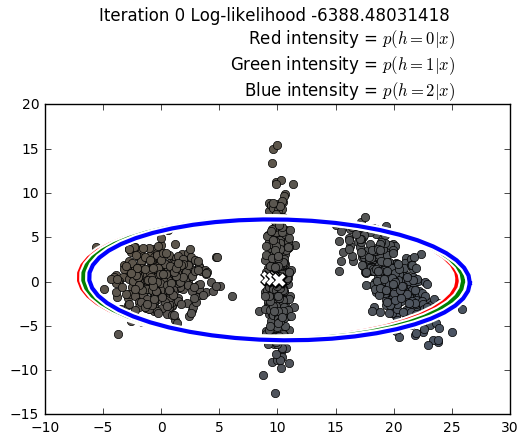

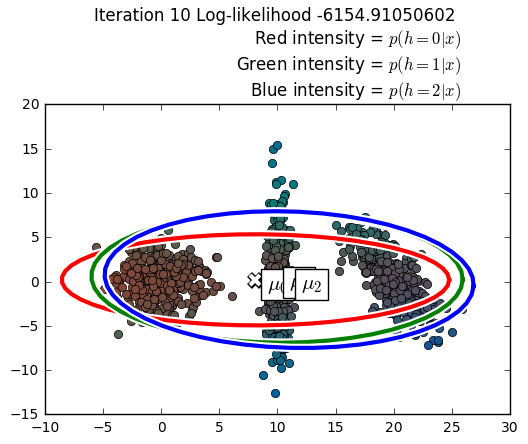

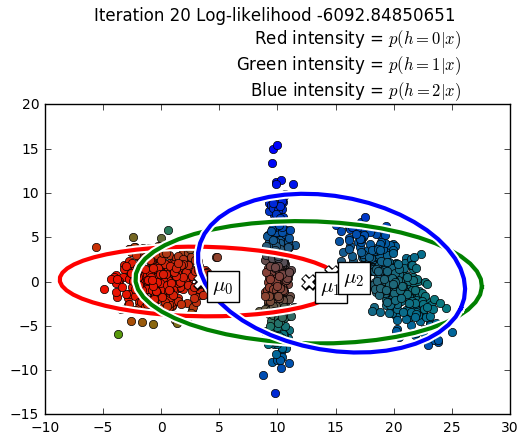

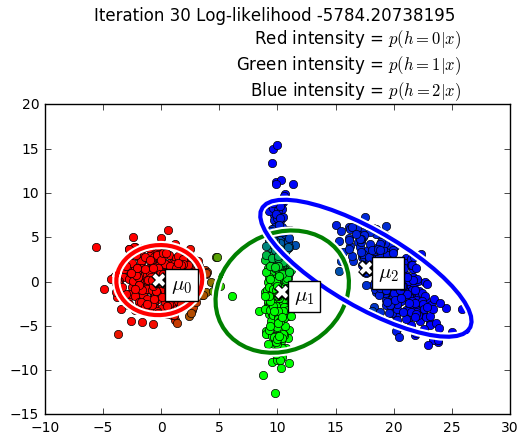

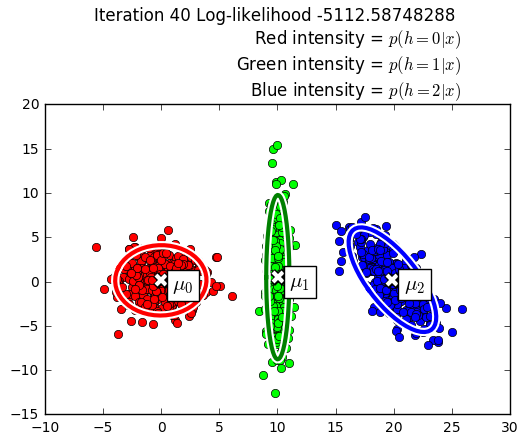

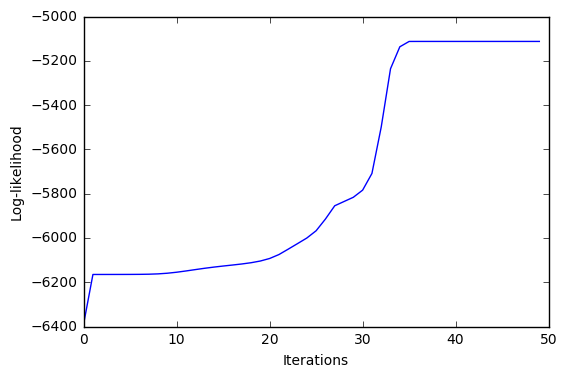

In [5]:
def logsumexp(vec):
    m = numpy.max(vec,axis=0)    
    return numpy.log(numpy.sum(numpy.exp(vec-m),axis=0))+m

def mog(xs,K,iterations=10, visualize=False):
    d,N = xs.shape
    # compute mean and std of data    
    data_mean = numpy.mean(xs,axis=1)
    data_std = numpy.std(xs,axis=1)
    # initialize means around the data mean but
    # ensure they are not exactly the same by adding
    # small amount of noise
    mus = (data_mean[:,numpy.newaxis] + 
          0.1*data_std[:,numpy.newaxis]*numpy.random.randn(d,K))
    Sigmas = numpy.zeros((d,d,K))
    for k in range(K):
        # start with large covariance
        Sigmas[:,:,k] = 0.1*numpy.eye(d) + 10.*numpy.diag(data_std)
        

    # assume uniform prior 
    logph = numpy.array([-numpy.log(K)]*K)

    logliks = []
    for it in range(iterations):
        # E-step
        q = logjointp(xs,mus,Sigmas,logph)
        assert(q.shape[0] == K)
        loglik = numpy.sum(logsumexp(q))
        logliks.append(loglik)        
        q = numpy.exp(q - logsumexp(q))
        
        # M-step:        
        mus = numpy.dot(xs,q.transpose())/(1e-5 + numpy.sum(q,axis=1))
        logph = numpy.log(numpy.sum(q,axis=1)/N)
        for k in range(K):
            mu = mus[:,k]
            res = xs - mu[:,numpy.newaxis]
            Sigma = numpy.dot(q[k,:]*res,res.transpose())/numpy.sum(q[k,:])
            Sigmas[:,:,k] = Sigma
  
        if visualize and it % 10 == 0:
            print "Iteration: {} Log-likelihood: {} ".format(it,loglik)
            plt.figure()
            
            plot_samples_post(xs,q,mus,Sigmas,label_means=it>0)
            plt.title(('Iteration {} Log-likelihood {} \n '+ 
                       'Red intensity = $p(h=0|x)$\n'+
                       'Green intensity = $p(h=1|x)$\n' +
                       'Blue intensity = $p(h=2|x)$').format(it,loglik),
                        multialignment='right')

       
    plt.figure()
    plt.plot(logliks)
    plt.xlabel('Iterations')
    plt.ylabel('Log-likelihood')
    alphas = numpy.exp(logph)
    return mus,alphas,q

  
mog(xs,3,iterations=50,visualize=True);

# Debugging EM

1. Log-likelihood should always go up!
2. Synthetic data is your friend. If you generate data from your model you get samples and cluster membership.
3. E-step computes cluster membership based on parameters. Use this!
    * Synthesize data from ground truth parameters 
    * Start your EM from ground truth parameters, not random initialization
    * Does your E step associate samples with correct clusters?
    * Select one sample and look at its posterior probability for the cluster it came from
4. M-step updates parameters based on cluster membership. Use this!
    * Using synthetic data, set ```q``` to be one-hot according to ground truth
    * Start your M-step with this ```q```
    * If you don't get parameters back that are close to the ground truth
    * To isolate a broken update, let M-step update just one parameter (for example mus)
5. Starting your EM with ground truth parameters should not budge too much.
    
Between these tricks you should be able to isolate source of your problem.


# MapReduce

`map` is a common function in functional programming languages

Here is an implementation in python
```
def map(f,lst):
    return [f(v) for v in lst]
```

`fold` or `reduce` is its companion
```
def reduce(f,lst,a):
    if len(lst) == 0
        return a
    return f(lst[0],reduce(f,lst[1:],a))
``` 

In [15]:
# simple map and reduce examples
def map(f,lst):
    return [f(v) for v in lst]

def reduce(f,lst,a):
    if len(lst) == 0:
        return a
    return f(lst[0],reduce(f,lst[1:],a))

def square(x):
    return x**2

def add(x,y):
    return x+y
def square(x):
    return x**2

lst = [1,2,3,4,5]
sqlist = map(square, [1,2,3,4,5])
print "Sum of squares map-reduce style:", reduce(add,sqlist,0)
print "Sum of squares numpy style:", numpy.sum(numpy.asarray(lst)**2)


Sum of squares map-reduce style: 55
Sum of squares numpy style: 55


# MapReduce for EM

1. `map` applies a function to each entry in a list
    * in our example: squaring
2. `reduce` summarizes the resulting list
    * in our example: sum
    
In the case of EM algorithm
1. In E-step, for each sample we compute $q(h_t) = p(h_t\mid \xx_t,\Theta)$ -- map
2. In M-step, we aggregate data 
$\mu_c^* = \frac{\sum_t q_t(c) \xx_t}{\sum_t q_t(c)}$ -- reduce

The main point here is that both ```map``` and ```reduce``` phase can be divided into subtasks
* compute $q(h)$ for subsets of data
* aggregate weighted sums for subsets of data

# MapReduce for EM

Hence, EM permits trivial parallelization.

MapReduce, despite the fact that it is a standard func. programming concept and implemented in various guises all over the place, is patented by Google.

Regardless, it is a good idea to take note of the parallelization opportunities.

Hadoop is a popular and robust open source implementation.

# Covered

* Mixture of Gaussian with Covariances
* Details of update derivation for means, covariances
* Debugging EM
* MapReduce